# PreProcess Data

==>> holton_mass_data_normalized shape: (309700, 75)
==>> holton_mass_input_all: (309699, 76)
==>> State A samples: (166534, 76)
==>> State B samples: (121164, 76)


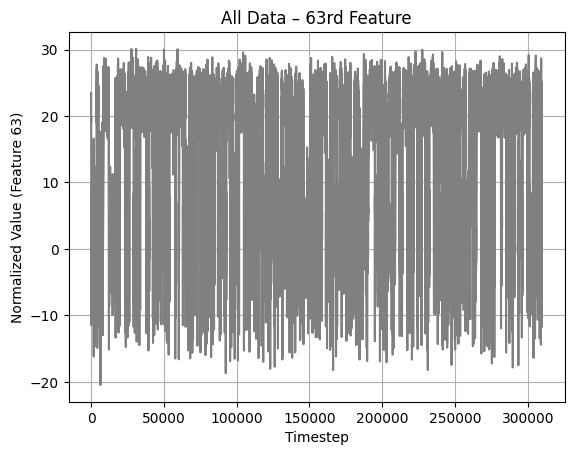

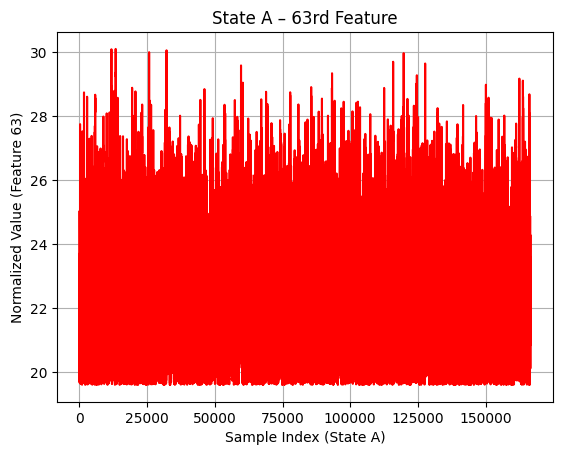

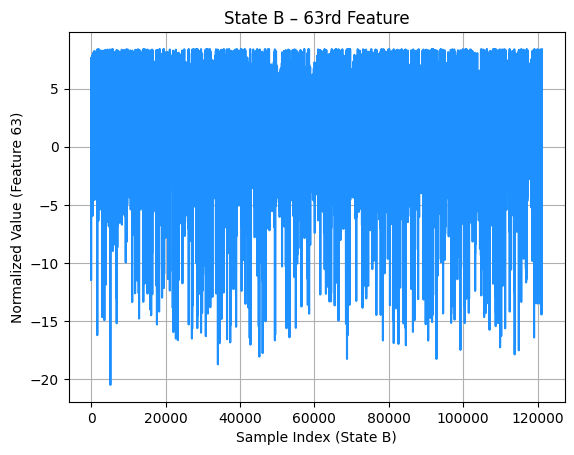

In [1]:
import numpy as np
import scipy
from scipy.stats import norm
import matplotlib.pyplot as plt
from numpy import linalg

holton_mass_data_normalized = np.load(r"c:\users\danie\onedrive\desktop\work_torch\long_run_310k.npy")
holton_mass_data_normalized = holton_mass_data_normalized[:, 0, :]
shape = (holton_mass_data_normalized.shape[0] *2, 75)

# holton_mass_data = np.reshape(holton_mass_data, shape)
# holton_mass_data_normalized = (holton_mass_data - np.mean(holton_mass_data, axis = 0))  / np.std(holton_mass_data, axis = 0)
print(f"==>> holton_mass_data_normalized shape: {holton_mass_data_normalized.shape}")

lead = 1

# All Data in Both States and Transition Region
holton_mass_input_all =  holton_mass_data_normalized[0:holton_mass_data_normalized.shape[0] - lead, :]
holton_mass_label_all = holton_mass_data_normalized[lead:holton_mass_data_normalized.shape[0], :]

assert np.all(holton_mass_input_all[100_001, :] == holton_mass_label_all[100_000, :]), "Ensure the input and label data are properly offset by lead"

holton_mass_input_all = np.append(holton_mass_input_all, np.ones((holton_mass_input_all.shape[0], 1)), axis=1)
print(f"==>> holton_mass_input_all: {holton_mass_input_all.shape}")

upper_bound =  19.59
lower_bound =  8.41

#Data in State A
state_A_indices = np.where(holton_mass_data_normalized[:-1, 63] > upper_bound)[0]
holton_mass_input_A = (holton_mass_data_normalized[state_A_indices])
holton_mass_input_A = np.append(holton_mass_input_A, np.ones((holton_mass_input_A.shape[0], 1)), axis=1)
holton_mass_label_A = holton_mass_data_normalized[state_A_indices+lead, :]
print(f"==>> State A samples: {holton_mass_input_A.shape}")

#Data in State B
state_B_indices = np.where(holton_mass_data_normalized[:-1, 63] < lower_bound)[0]
holton_mass_input_B = (holton_mass_data_normalized[state_B_indices])
holton_mass_input_B = np.append(holton_mass_input_B, np.ones((holton_mass_input_B.shape[0], 1)), axis=1)
holton_mass_label_B = holton_mass_data_normalized[state_B_indices+lead, :]
print(f"==>> State B samples: {holton_mass_input_B.shape}")

plt.figure()
plt.plot(holton_mass_data_normalized[:, 63], color='gray')
plt.title("All Data – 63rd Feature")
plt.xlabel("Timestep")
plt.ylabel("Normalized Value (Feature 63)")
plt.grid(True)

plt.figure()
plt.plot(holton_mass_input_A[:, 63], color='red')
plt.title("State A – 63rd Feature")
plt.xlabel("Sample Index (State A)")
plt.ylabel("Normalized Value (Feature 63)")
plt.grid(True)

plt.figure()
plt.plot(holton_mass_input_B[:, 63], color='dodgerblue')
plt.title("State B – 63rd Feature")
plt.xlabel("Sample Index (State B)")
plt.ylabel("Normalized Value (Feature 63)")
plt.grid(True)

plt.show()


# Find Linear Model Coeffecients

In [2]:
def linear_model_coeffs(X, Y):
    M_bias, resids, rank, singular_values = np.linalg.lstsq(X, Y)
    M = M_bias[:-1, :].T
    c = M_bias[-1:, :].T
    residuals = Y - X @ M_bias
    BBT = residuals.T @ residuals / (residuals.shape[0] - 1)
    return M, c, BBT

# Determine Stationary Distribution

In [3]:
def stationary_distribution (M, c, BBT):
    mu = np.linalg.inv((np.eye(M.shape[0]) - M)) @ c
    gamma = scipy.linalg.solve_discrete_lyapunov(M, BBT)
    return mu, gamma

# Marginal Distributions

In [4]:

def plot_marginal_distributions(feature_indices, mu, gamma, normalized_data):
    num_features = len(feature_indices)
    n_cols = 3  
    n_rows = (num_features + n_cols - 1) // n_cols  

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten()  

    for i, index in enumerate(feature_indices):
        mean = mu[index]
        std = np.sqrt(gamma[index, index])

        empirical_values = normalized_data[:, index]
        x = np.linspace(np.min(empirical_values), np.max(empirical_values), 500)
        pdf = norm.pdf(x, mean, std)

        print(f"Feature {index} | mu: {mean.item():.2f}, std: {std.item():.2f}, max PDF height: {pdf.max():.4f}")
        ax = axes[i]
        ax.hist(empirical_values, bins=100, density=True, alpha=0.5, label='Holton Mass Empirical', color='dodgerblue')
        ax.plot(x, pdf, color='green', label='Linear Model Gaussian')
        ax.set_title(f"Feature {index}")
        ax.set_xlabel("Value")
        ax.grid(True)
        ax.legend()

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# 1st Linear Model, Evolve Under Data in State A and B

Max |eigvals(M)| = 0.9707693148372099
Feature 13 | mu: 1.56, std: 0.84, max PDF height: 0.4734
Feature 37 | mu: 0.42, std: 0.86, max PDF height: 0.4658
Feature 63 | mu: 22.56, std: 2.12, max PDF height: 0.1885


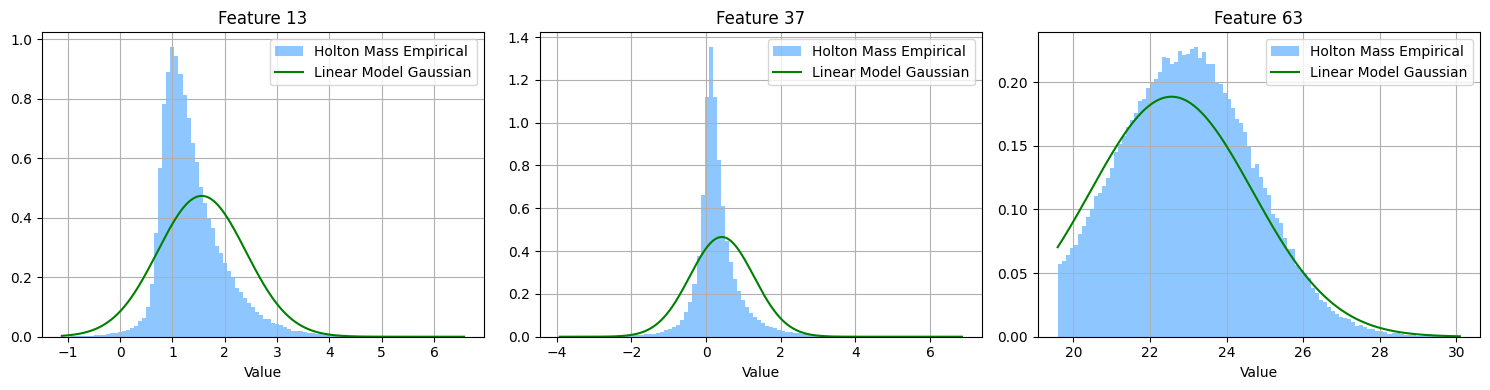

Max |eigvals(M)| = 0.9802822981405912
Feature 13 | mu: -0.66, std: 1.74, max PDF height: 0.2295
Feature 37 | mu: 0.45, std: 2.48, max PDF height: 0.1609
Feature 63 | mu: 1.84, std: 3.25, max PDF height: 0.1227


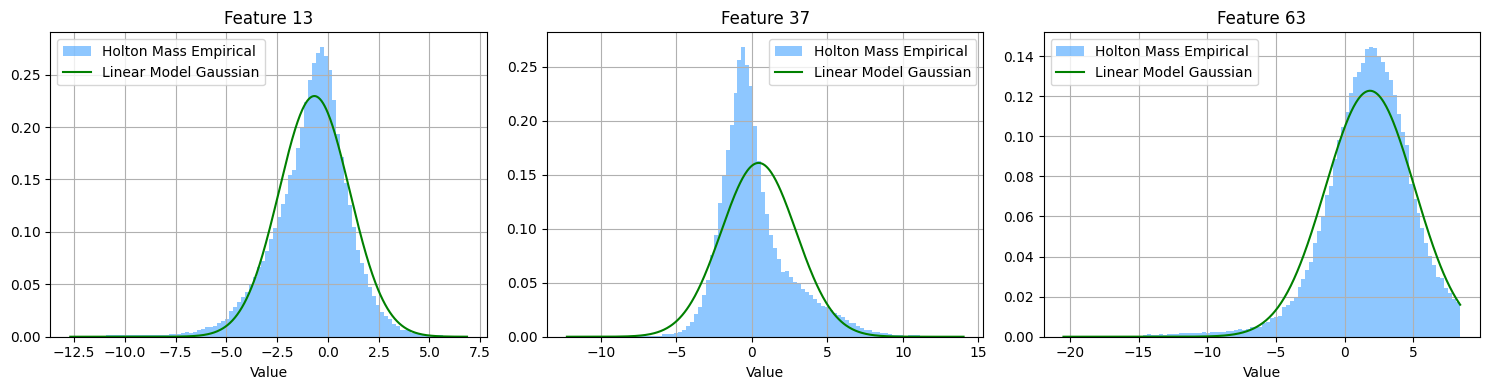

In [5]:
feature_indices = [13, 37, 63]
M, c, BBT = linear_model_coeffs(holton_mass_input_A, holton_mass_label_A)
eigvals = np.linalg.eigvals(M)
print("Max |eigvals(M)| =", np.max(np.abs(eigvals)))
mu, gamma = stationary_distribution(M, c, BBT)
plot_marginal_distributions(feature_indices, mu, gamma, holton_mass_input_A)

M, c, BBT = linear_model_coeffs(holton_mass_input_B, holton_mass_label_B)
eigvals = np.linalg.eigvals(M)
print("Max |eigvals(M)| =", np.max(np.abs(eigvals)))
mu, gamma = stationary_distribution(M, c, BBT)
plot_marginal_distributions(feature_indices, mu, gamma, holton_mass_input_B)

# 2nd Linear Model, Evolve Under Data in State A and B

Max |eigvals(M)| = 0.9950496583745734
Feature 13 | mu: 0.55, std: 1.84, max PDF height: 0.2169
Feature 37 | mu: 0.47, std: 1.95, max PDF height: 0.2042
Feature 63 | mu: 14.14, std: 10.49, max PDF height: 0.0380


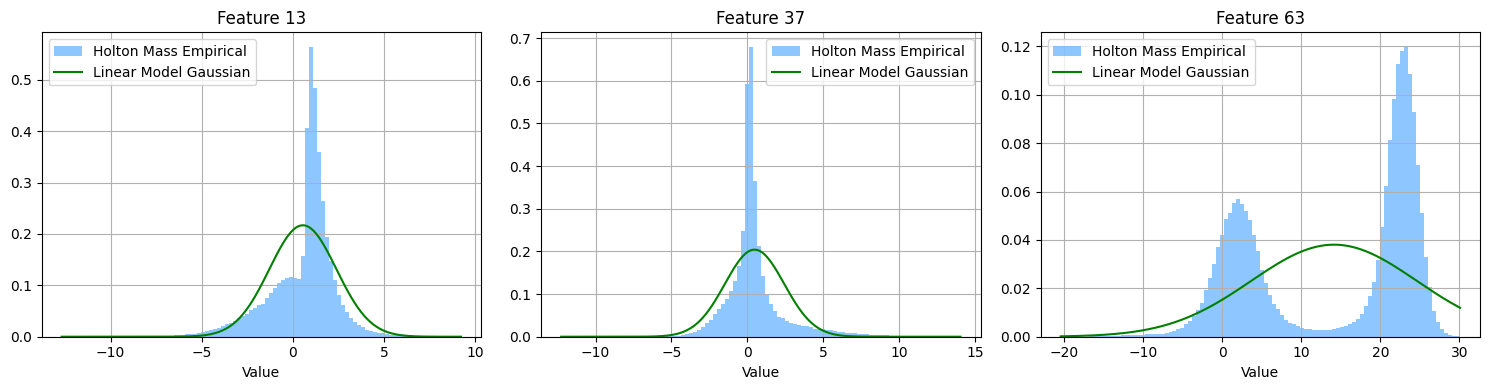

In [6]:
M, c, BBT = linear_model_coeffs(holton_mass_input_all, holton_mass_label_all)
eigvals = np.linalg.eigvals(M)
print("Max |eigvals(M)| =", np.max(np.abs(eigvals)))
mu, gamma = stationary_distribution(M, c, BBT)
plot_marginal_distributions(feature_indices, mu, gamma, holton_mass_input_all)

# EDMD

In [ ]:
import numpy as np
import scipy
from scipy.stats import norm
import matplotlib.pyplot as plt
from numpy import linalg

def augment_with_quadratic(X):
    n_samples, n_features = X.shape
    n_aug = n_features + (n_features * (n_features + 1)) // 2 
    X_aug = np.zeros((n_samples, n_aug))  

    # Linear terms
    X_aug[:, :n_features] = X

    # Quadratic terms
    idx = n_features
    for i in range(n_features):
        for j in range(i, n_features):
            if (idx >= n_aug):
                break
            X_aug[:, idx] = X[:, i] * X[:, j]
            idx += 1

    print(f"==>> X_aug.shape: {X_aug.shape}")
    print(f"==>> idx: {idx}")
    return X_aug


holton_mass_data = np.load(r"c:\users\danie\onedrive\desktop\work_torch\long_run_310k.npy")
holton_mass_data = holton_mass_data[:, 0, :]

#This will augment the data with quadratic features
holton_mass_data_augmented = augment_with_quadratic(holton_mass_data)
print(f"Original dimension: {holton_mass_data.shape[1]}")
print(f"Augmented dimension: {holton_mass_data_augmented.shape[1]}")

lead = 1
upper_bound = 18.59 
lower_bound = 7.41

def prepare_augmented_data(data_augmented, original_data, lead, bound, comparison_op):
    indices = np.where(comparison_op(original_data[:-1, 63], bound))[0]
    X = data_augmented[indices]
    Y = data_augmented[indices + lead]
    return X, Y, indices

#All the data in state A
X_A_aug, Y_A_aug, state_A_indices = prepare_augmented_data(
holton_mass_data_augmented, holton_mass_data, lead, upper_bound, np.greater)
X_A_aug = np.append(X_A_aug, np.ones((X_A_aug.shape[0], 1)), axis=1)
print(f"==>> X_A_aug.shape: {X_A_aug.shape}")

#All the data in state B
X_B_aug, Y_B_aug, state_B_indices = prepare_augmented_data(
holton_mass_data_augmented, holton_mass_data, lead, lower_bound, np.less)
X_B_aug = np.append(X_B_aug, np.ones((X_B_aug.shape[0], 1)), axis=1)
print(f"==>> X_B_aug.shape: {X_B_aug.shape}")

#All the data in both states and transition region
X_all_aug = holton_mass_data_augmented[0:holton_mass_data_augmented.shape[0]-lead, :]
X_all_aug = np.append(X_all_aug, np.ones((X_all_aug.shape[0], 1)), axis=1)
print(f"==>> X_all_aug.shape: {X_all_aug.shape}")
Y_all_aug = holton_mass_data_augmented[lead:]

feature_indices = [13, 37, 63, 75, 76, 100, 112, 125, 137, 150, 162, 175, 188, 200]

print("\n=== State A Analysis ===")
M_A, c_A, BBT_A = linear_model_coeffs(X_A_aug, Y_A_aug)
eigvals = np.linalg.eigvals(M_A[:, :])  
print("Max |eigvals(M)| =", np.max(np.abs(eigvals)))
mu_A, gamma_A = stationary_distribution(M_A, c_A, BBT_A)
plot_marginal_distributions(feature_indices, mu_A, gamma_A, X_A_aug)

print("\n=== State B Analysis ===")
M_B, c_B, BBT_B = linear_model_coeffs(X_B_aug, Y_B_aug)
eigvals = np.linalg.eigvals(M_B[:, :])  
print("Max |eigvals(M)| =", np.max(np.abs(eigvals)))
mu_B, gamma_B = stationary_distribution(M_B, c_B, BBT_B)
plot_marginal_distributions(feature_indices, mu_B, gamma_B, X_B_aug) 

print("\n=== All Data Analysis ===")
M_all, c_all, BBT_all = linear_model_coeffs(X_all_aug, Y_all_aug)
eigvals = np.linalg.eigvals(M_all[:, :])
print("Max |eigvals(M)| =", np.max(np.abs(eigvals)))
mu_all, gamma_all = stationary_distribution(M_all, c_all, BBT_all)
plot_marginal_distributions(feature_indices, mu_all, gamma_all, X_all_aug)

==>> X_aug.shape: (309700, 2925)
==>> idx: 2925
Original dimension: 75
Augmented dimension: 2925
==>> X_A_aug.shape: (173112, 2926)
==>> X_B_aug.shape: (118756, 2926)
==>> X_all_aug.shape: (309699, 2926)

=== State A Analysis ===
